# Imports

In [1]:
! pip install transformers
! pip install datasets
! pip install evaluate
! pip install sentencepiece
! pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.8 MB/s eta 0:00:00


In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-24 20:49:59--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-24 20:50:00 (75.7 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import calculate_results, plot_loss_curves, make_confusion_matrix

In [4]:
import tensorflow as tf
import numpy as np
from google.colab import drive
from google.colab import files
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import (create_optimizer,T5TokenizerFast,DataCollatorForSeq2Seq,TFT5ForConditionalGeneration,
                          TFAutoModelForSeq2SeqLM,AutoModelForSeq2SeqLM,TFT5ForConditionalGeneration)
import pandas as pd
import re
from datasets import Dataset

In [5]:
BATCH_SIZE = 64
MAX_LENGTH = 128

# Data loading

In [6]:
! pip install -q kaggle
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d vaibhavkumar11/hindi-english-parallel-corpus
! unzip "/content/hindi-english-parallel-corpus.zip" -d "/content/dataset"

 99% 111M/112M [00:04<00:00, 35.3MB/s]
100% 112M/112M [00:04<00:00, 26.4MB/s]
Archive:  /content/hindi-english-parallel-corpus.zip
  inflating: /content/dataset/hindi_english_parallel.csv  


In [7]:
df = pd.read_csv("/content/dataset/hindi_english_parallel.csv", encoding='utf-8')
df.head(5)

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [8]:
df.duplicated().sum()

203501

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.isnull().sum()

hindi      4391
english      38
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
def standardization(input_data):
  input_data = str(input_data)
  no_tag = re.sub(r'<.*?>', '', input_data)
  no_url = re.sub(r'https?://\S+|www\.\S+', '', no_tag)
  return no_url

In [13]:
df['hindi'] = df['hindi'].apply(standardization)
df['english'] = df['english'].apply(standardization)

In [14]:
hindi_sentences = []
english_sentences = []
for hindi, english in zip(df['hindi'], df['english']):
  hindi = str(hindi)
  english = str(english)
  hindi_length = len(hindi.split())
  english_length = len(english.split())
  if (hindi_length >= 10) and (english_length >= 10):
   hindi_sentences.append(hindi)
   english_sentences.append(english)

In [15]:
df = pd.DataFrame(list(zip(hindi_sentences, english_sentences)), columns =['hindi', 'english'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646046 entries, 0 to 646045
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   hindi    646046 non-null  object
 1   english  646046 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [17]:
df = df.sample(50000)

In [18]:
hindi_sequence_len = [len(sentence.split()) for sentence in df['hindi']]
avg_hindi_sequence_len = np.mean(hindi_sequence_len)
english_sequence_len = [len(sentence.split()) for sentence in df['english']]
avg_english_sequence_len = np.mean(english_sequence_len)

print("Avg Hindi Sequence Length:", avg_hindi_sequence_len)
print("Avg English Sequence Length:", avg_english_sequence_len)

Avg Hindi Sequence Length: 26.64928
Avg English Sequence Length: 24.47412


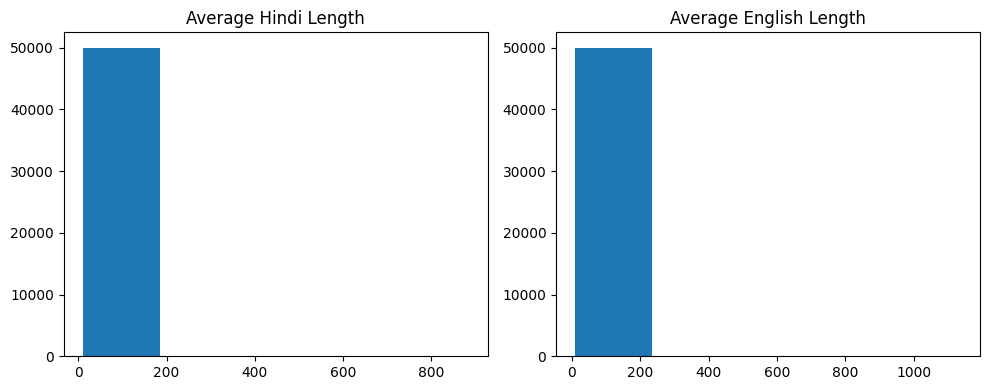

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Average Hindi Length")
plt.hist(hindi_sequence_len, bins=5)

plt.subplot(1, 2, 2)
plt.title("Average English Length")
plt.hist(english_sequence_len, bins=5)

plt.tight_layout()
plt.show()

In [20]:
output_hindi_sequence_len = int(np.percentile(hindi_sequence_len, 95))
output_english_sequence_len = int(np.percentile(english_sequence_len, 95))
print("Output Hindi Sequence Length:", output_hindi_sequence_len)
print("Output English Sequence Length:", output_english_sequence_len)

Output Hindi Sequence Length: 59
Output English Sequence Length: 53


In [21]:
dataset = Dataset.from_pandas(df)

In [22]:
dataset

Dataset({
    features: ['hindi', 'english', '__index_level_0__'],
    num_rows: 50000
})

In [24]:
print(dataset[0])

{'hindi': '(मुसलमानों) अहले किताब में से अक्सर लोग अपने दिली हसद की वजह से ये ख्वाहिश रखते हैं कि तुमको ईमान लाने के बाद फिर काफ़िर बना दें (और लुत्फ तो ये है कि) उन पर हक़ ज़ाहिर हो चुका है उसके बाद भी (ये तमन्ना बाक़ी है) पस तुम माफ करो और दरगुज़र करो यहाँ तक कि खुदा अपना (कोई और) हुक्म भेजे बेशक खुदा हर चीज़ पर क़ादिर है', 'english': 'Many of the People of the Scripture wish they could turn you back to disbelief after you have believed, out of envy from themselves [even] after the truth has become clear to them. So pardon and overlook until Allah delivers His command. Indeed, Allah is over all things competent.', '__index_level_0__': 112642}


# Tokenizer

In [25]:
model_id = 't5-small'
tokenizer = T5TokenizerFast.from_pretrained(model_id)

In [27]:
MAX_LENGTH = 60

def preprocess_function(examples):
  inputs = [example for example in examples['english']]
  target = [example for example in examples['hindi']]
  tokenized_output = tokenizer(inputs, text_target=target, max_length=MAX_LENGTH, truncation=True)
  return tokenized_output

In [29]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [30]:
tokenized_dataset

Dataset({
    features: ['hindi', 'english', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 50000
})

In [31]:
# tokenized_dataset['train'][101]

In [32]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_id)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [34]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors='tf')

In [36]:
dataset = tokenized_dataset.to_tf_dataset(
    batch_size=BATCH_SIZE,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [37]:
total_samples = len(dataset)

train_samples = int(0.8 * total_samples)
val_samples = total_samples - train_samples

tf_train_dataset = dataset.take(train_samples)
tf_val_dataset = dataset.skip(train_samples)

In [38]:
for i in tf_val_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(64, 60), dtype=int64, numpy=
array([[ 5306,    16,     8, ...,     0,     0,     0],
       [ 5417,  3540,  1592, ...,     5,     3,     1],
       [  264,  1215,   138, ...,     0,     0,     0],
       ...,
       [  264,    79,  5944, ...,     0,     0,     0],
       [ 2759, 12273,  5005, ...,     0,     0,     0],
       [ 5882,    21,   321, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 60), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(64, 60), dtype=int64, numpy=
array([[   3,    2,    3, ..., -100, -100, -100],
       [   3,    2,    3, ...,    2,    3,    1],
       [   3,    2,    3, ..., -100, -100, -100],
       ...,
       [   3,    2,    3, ..., -100, -100, -100],
       [   3,    2,    3, ..., -100, -100, -

In [40]:
num_epochs = 5
num_train_steps = len(tf_train_dataset) * num_epochs
optimizer, schedule = create_optimizer(init_lr = 2e-5,
                                      num_warmup_steps = 0,
                                      num_train_steps = num_train_steps)
model.compile(optimizer=optimizer)

In [41]:
history = model.fit(tf_train_dataset,
                   validation_data = tf_val_dataset,
                   epochs = 5)

Epoch 1/5
625/625 [==============================] - 458s 624ms/step - loss: 0.3643 - val_loss: 0.2741
Epoch 2/5
625/625 [==============================] - 384s 615ms/step - loss: 0.2893 - val_loss: 0.2588
Epoch 3/5
625/625 [==============================] - 385s 615ms/step - loss: 0.2755 - val_loss: 0.2551
Epoch 4/5
625/625 [==============================] - 383s 614ms/step - loss: 0.2695 - val_loss: 0.2514
Epoch 5/5
625/625 [==============================] - 382s 611ms/step - loss: 0.2664 - val_loss: 0.2487


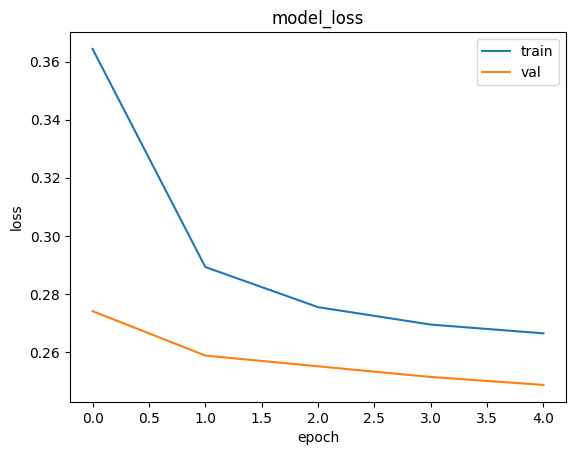

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

# Evaluation

In [43]:
! pip install sacrebleu

In [44]:
import sacrebleu

all_preds = []
all_labels = []

for batch in tf_val_dataset.take(10):
    predictions = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

bleu_score = sacrebleu.corpus_bleu(all_preds, all_labels)
print(bleu_score)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:834: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 1 ref_len = 1)


# Model at inference

In [47]:
#text you want translate
texts = ["I spend a few hours a day maintaining my website.",
        "Where do random thoughts come from?",
        "I can't believe that she is older than my mother.",
        "My Mum tries to be cool by saying that she likes all the same things that I do",
        "A song can make or ruin a person’s day if they let it get to them."]

inputs = tokenizer(texts, padding="longest", max_length=60, truncation=True, return_tensors='tf')
output = model.generate(**inputs, max_length=128)
for i in range(len(texts)):
    print(texts[i] + " ------------> " + tokenizer.decode(output[i], skip_special_tokens=True))

I spend a few hours a day maintaining my website. ------------>                 
Where do random thoughts come from? ------------>                               
I can't believe that she is older than my mother. ------------>                    
My Mum tries to be cool by saying that she likes all the same things that I do ------------>                              
A song can make or ruin a person’s day if they let it get to them. ------------>                              


# Saving a Model

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

In [48]:
model.save("English_Hindi_Translation")

In [ ]:
loaded_model = load_model("English_Hindi_Translation")

# Hugging Face

In [49]:
! pip install huggingface_hub

In [55]:
from huggingface_hub import notebook_login
notebook_login()

In [56]:
model.push_to_hub("DriveMyScream/English_Hindi_Translation")
tokenizer.push_to_hub("DriveMyScream/English_Hindi_Translation")

tf_model.h5:   0%|          | 0.00/374M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DriveMyScream/Grammatical_Error_Correction/commit/07b025d67c946a7a6ce4aae77272cdbef05ec391', commit_message='Upload tokenizer', commit_description='', oid='07b025d67c946a7a6ce4aae77272cdbef05ec391', pr_url=None, pr_revision=None, pr_num=None)

In [57]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

pretrained_model = AutoModelForSeq2SeqLM.from_pretrained("DriveMyScream/English_Hindi_Translation", from_tf=True)
tokenizer = AutoTokenizer.from_pretrained("DriveMyScream/English_Hindi_Translation", from_tf=True)

All TF 2.0 model weights were used when initializing T5ForConditionalGeneration.

Some weights of T5ForConditionalGeneration were not initialized from the TF 2.0 model and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
#text you want translate
texts = ["I spend a few hours a day maintaining my website.",
        "Where do random thoughts come from?",
        "I can't believe that she is older than my mother.",
        "My Mum tries to be cool by saying that she likes all the same things that I do",
        "A song can make or ruin a person’s day if they let it get to them."]

inputs = tokenizer(texts, padding="longest", max_length=60, truncation=True, return_tensors='tf')
output = model.generate(**inputs, max_length=128)
for i in range(len(texts)):
    print(texts[i] + " --> " + tokenizer.decode(output[i], skip_special_tokens=True))

I spend a few hours a day maintaining my website. -->                 
Where do random thoughts come from? -->                               
I can't believe that she is older than my mother. -->                    
My Mum tries to be cool by saying that she likes all the same things that I do -->                              
A song can make or ruin a person’s day if they let it get to them. -->                              


# Tensorflow Lite

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "English_Hindi_Translation.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "/content/English_Hindi_Translation.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#text you want translate
texts = ["I spend a few hours a day maintaining my website.",
        "Where do random thoughts come from?",
        "I can't believe that she is older than my mother.",
        "My Mum tries to be cool by saying that she likes all the same things that I do",
        "A song can make or ruin a person’s day if they let it get to them."]

inputs = tokenizer(texts, padding="longest", max_length=60, truncation=True, return_tensors='tf')
output = model.generate(**inputs, max_length=128)
for i in range(len(texts)):
    print(texts[i] + " ------------> " + tokenizer.decode(output[i], skip_special_tokens=True))